# Multiband Dynamic Range Compressor

This example shows how to run the multiband dynamic range compressor (MBC) from the `clarity` module.
The theoretical part of this tutorial is based on the [MATLAB documentation](https://www.mathworks.com/help/audio/ug/multiband-dynamic-range-compression.html) 

## Introduction

Dynamic range compression reduces the dynamic range of a signal by lowering the level of strong peaks while leaving weaker ones unaffected. It is used in audio recording, mixing, and broadcasting.

Multiband compression applies compression to different frequency bands separately. The audio signal is split into multiple bands using a crossover filter, and each band is processed through its own adjustable compressor. In Cadenza, Linkwitz-Riley crossover filters are used to maintain a smooth frequency response. Compressor parameters like compression ratio, attack/release time, threshold, and knee width can be individually adjusted for each band, allowing detailed control over the signal's dynamic range.

:::{admonition} Google Colab
:class: warning
To run this tutorial on Google Colab, you will need install the PyClarity module by uncommenting and running the next cell.
:::

In [1]:
# print("Cloning git repo...")
# !git clone --depth 1 --branch v0.6.1 https://github.com/claritychallenge/clarity.git

# print("Installing the pyClarity...\n")
# %cd clarity
# %pip install -e .

# clear_output()
# print("Repository installed")

### Linkwitz–Riley filter

Linkwitz–Riley crossover filter is a combination of lowpass and highpass filters. Each filter is a cascade of lowpass or highpass Butterworth filters. The sum of both filters yields 0 dB at the crossover fequency so that the crossover acts like an allpass filter (and therefore introducing no distortion in the audio signal).

In clarity package, the Linkwitz–Riley crossover filters can be computed by using the `Crossover` class stored in the `clarity/enhancer/multiband_compressor/crossover.py` module.
our implementation of the crossover filters is based on {cite}`d1984active`. We generalise the filter to compute any number of crossovers of order 4. 

Let's run a filter of a random signal at a crossover frequency of 8000 Hz.

In [44]:
import numpy as np
from clarity.enhancer.multiband_compressor import Crossover

# Create our random signal
signal = np.random.randn(1000)

# Crossover Frequency
xover_freqs = 8000

# Create the Crossover instance
xover = Crossover(xover_freqs)

# Filter the fignal
filtered_signal = xover(signal)

Let's see the shape of the filtered signal, we should have **2** bands with **1000** samples

In [45]:
filtered_signal.shape

(2, 1000)

The class also offers a `plot_filter()` method that helps to visualize the filter we just have created.
* The Blue line shows the lowpass filter
* The Orange line shows the highpass filter
* The Green line shows the sum of both filters.

The Blue and Orange line intersect at the crossover frequency (8000 Hz).  

If our filters are correct, the green line should be a flat line at 0 dB.

1.582634951557923e-10


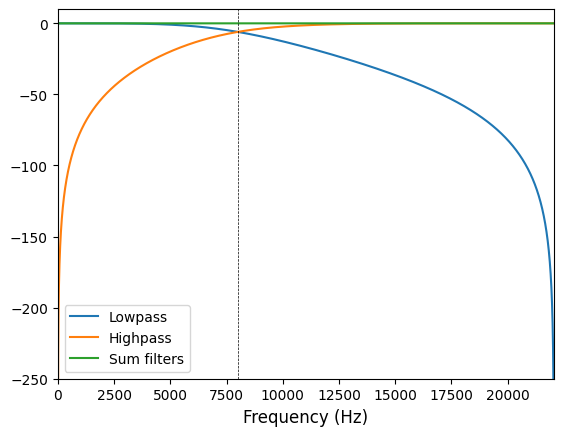

In [46]:
import  matplotlib.pyplot as plt

x = np.concatenate(([1], np.zeros(65500)))
y = xover(x)

fplt = np.linspace(0, xover.sample_rate, len(x))

plt.figure()

labels = ['Lowpass', 'Highpass']
for i in range(len(xover.xover_freqs) + 1):
    Y = np.fft.fft(y[i, :])
    plt.plot(fplt, 20 * np.log10(np.abs(Y)), label=labels[i])

ytotal = np.sum(y, axis=0)
Ytotal = np.fft.fft(ytotal)
plt.plot(
    fplt,
    20 * np.log10(np.abs(Ytotal)), label='Sum filters'
)
print(np.sum(20 * np.log10(np.abs(Ytotal))))

plt.axvline(x = 8000, c='black', ls='--', lw='0.5')

plt.xlim([-10, int(xover.sample_rate / 2)])
plt.ylim([-250, 10])

plt.xlabel('Frequency (Hz)', fontsize=12)

plt.legend()
plt.show()

---
Now, let's run another filter with 2 crossover filters. In this case 3 filters should be created, a lowpass, bandpass and highpass filters.

In [40]:
# Crossover Frequency
xover_freqs = [6000, 10000]

# Create the Crossover instance
xover = Crossover(xover_freqs)

# Filter the fignal
filtered_signal = xover(signal)

-1.9156461555827714e-10


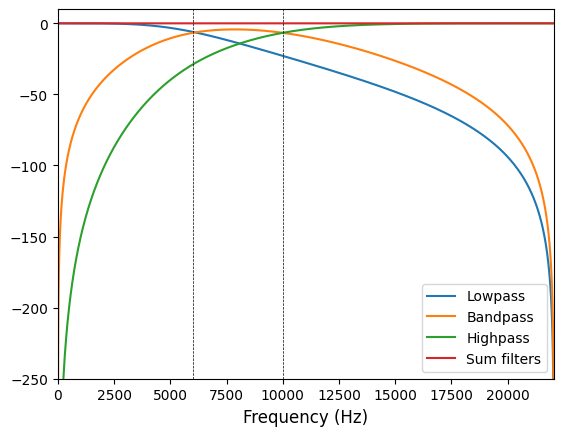

In [43]:
x = np.concatenate(([1], np.zeros(65500)))
y = xover(x)

fplt = np.linspace(0, xover.sample_rate, len(x))

plt.figure()

labels = ['Lowpass', 'Bandpass', 'Highpass']
for i in range(len(xover.xover_freqs) + 1):
    Y = np.fft.fft(y[i, :])
    plt.plot(fplt, 20 * np.log10(np.abs(Y)), label=labels[i])

ytotal = np.sum(y, axis=0)
Ytotal = np.fft.fft(ytotal)
plt.plot(
    fplt,
    20 * np.log10(np.abs(Ytotal)), label='Sum filters'
)
print(np.sum(20 * np.log10(np.abs(Ytotal))))

for xfreq in xover_freqs:
    plt.axvline(x=xfreq, c='black', ls='--', lw='0.5')

plt.xlim([-10, int(xover.sample_rate / 2)])
plt.ylim([-250, 10])

plt.xlabel('Frequency (Hz)', fontsize=12)

plt.legend()
plt.show()

---

## Digital Dynamic Range Compressor

The clarity implementation is based on {cite}`giannoulis2012digital`.

The objective of the dynamic range compressor mapping the dynamic range of an audio signal to a smaller range, i.e., reducing the signal level of the higher peaks while leaving the quieter parts untreated.

There are several parameters that affects how the compressor operates:
* Threshold: level at which compression starts.
* Ratio: is the input/output ratio for signals that overshoot the operation threshold.
* Attack times: time it takes the compressor to decrease the gain to the level determined by the ratio. 
* Release times: time it takes to bring the gain back up to the normal level once the signal has fallen below the threshold.
* Make-Up Gain: compensates for gain lost during compression. It is applied at the output of the dynamic range compressor
* Knee Width: controls whether the bend in the compression characteristic has a sharp angle or has a rounded edge.

In clarity, we provide a `Compressor` class located in `clarity/enhancer/multiband_compressor/compressor_qmul.py`.

Let's run an example. First we will load 10 seconds from a `librosa` audio sample.

In [94]:
import librosa
import matplotlib.pyplot as plt

signal, sr = librosa.load(
    librosa.ex("brahms"),
    sr=None,
    duration=10,
    mono=False
)
if signal.ndim == 1:
    signal = signal[np.newaxis, :]

Let's construct a new Compressor.

In [95]:
from clarity.enhancer.multiband_compressor import Compressor

compressor = Compressor(
    threshold=-30.0,
    ratio=1.5,
    attack=10.0,
    release=100.0,
    makeup_gain=1.25,
    knee_width=10.0,
    sample_rate=sr,
)

And now compress the signal and we can vizualise them.

In [96]:
compressed_signal = compressor(signal)

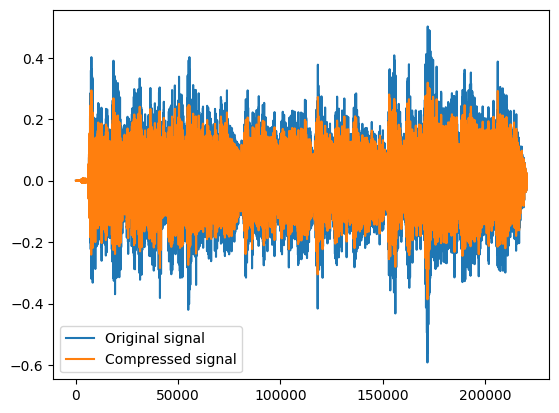

In [97]:
plt.figure()
plt.plot(signal[0], label='Original signal')
plt.plot(compressed_signal[0], label='Compressed signal')
plt.legend()
plt.show()

## Multiband Dynamic Range Compressor

Now that we understand the crossover filters and the compressor, we can put both together to perform an independent compression to each band.

The MBC is operates as follows: 

1. Create the crossover filters.
2. Separate the signal into number-of-filters + 1 bands.
3. Create number-of-filters + 1 compressors. one for each band.
4. Compress each band using its corresponding compressor.
5. Reconstruct the compressed signal by adding the compressed bands back together.

The class to perform this is called `MultibandCompressor` and it is located in `clarity/enhancer/multiband_compressor/multiband_compressor.py`.

This class needs a list of crossover frequencies and the compressor parameters for each band.

Let's see this in an example. First we will load 10 seconds from a `librosa` audio sample.

In [98]:
import librosa
import matplotlib.pyplot as plt

from clarity.enhancer.multiband_compressor import MultibandCompressor

signal, sample_rate = librosa.load(
   librosa.ex("brahms"),
   sr=None,
   duration=10,
   mono=False
)

For this example:
1. we will use listener L5076 from Cadenza validation set. 
2. the crossover frequencies will correspond to the boundaries of the audiogram centre frequencies [250, 500, 1000, 2000, 4000].

In [99]:
HL = np.array([15, 20, 30, 30, 50, 75])

# Compression ratios
cr = [1.0, 1.0, 1.1, 1.2, 1.6, 2.8]
# Gains
gain = [0.0, 1.5, 9.6, 13.2, 16.2, 25.8]

mbc = MultibandCompressor(
     # [250, 500, 1000, 2000, 4000] * sqrt(2)
    crossover_frequencies=[353.55, 707.11, 1414.21, 2828.43, 5656.85],
    sample_rate=sample_rate,
    compressors_params={
        "attack": [11, 11, 14, 13, 11, 11],
        "release": [80, 80, 80, 80, 100, 100],
        "threshold": -30,
        "ratio": cr,
        "makeup_gain": gain,
        "knee_width": 0,
    }
)

Before applying the compressor, we need to normalise the signal to -40 LUFS. This, to minimise the number of clipping.

In [100]:
import pyloudnorm as pyln

target_lufs = -40
level_meter = pyln.Meter(int(sample_rate))
input_level = level_meter.integrated_loudness(signal.T)

normalised_signal = signal * (10 ** ((target_lufs - input_level) / 20))

Now we can compress the signal

In [101]:
compressed_signal = mbc(normalised_signal, return_bands=False)

Let's see the output

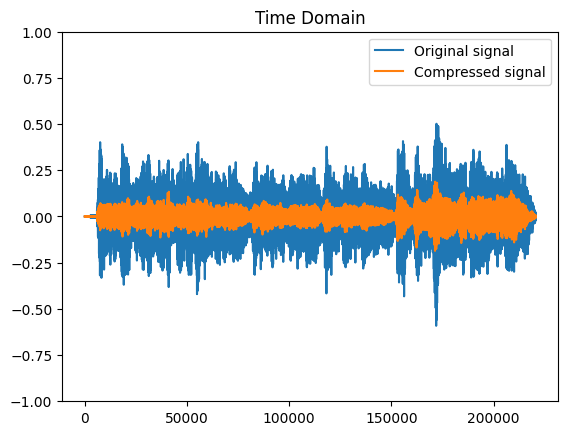

In [102]:
plt.figure()
plt.plot(signal, label='Original signal')
plt.plot(compressed_signal[0], label='Compressed signal')
plt.title("Time Domain")

plt.ylim(-1, 1)
plt.legend()
plt.show;